### import libraries

In [145]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import (
    OneHotEncoder,
    MinMaxScaler,
    PowerTransformer,
    FunctionTransformer,
    StandardScaler
)
from sklearn.pipeline import Pipeline,FeatureUnion
from feature_engine.encoding import (
    RareLabelEncoder,
    MeanEncoder,
    CountFrequencyEncoder,
    OrdinalEncoder
)
from feature_engine.selection import SelectBySingleFeaturePerformance
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics.pairwise import rbf_kernel
from feature_engine.datetime import DatetimeFeatures
from feature_engine.outliers import Winsorizer
import warnings
import matplotlib.pyplot as plt
import os
import xgboost as xgb

### Display Settings

In [2]:
pd.set_option('display.max_columns',None)

In [3]:
sklearn.set_config(transform_output='pandas')

In [4]:
warnings.filterwarnings('ignore')

### Read Data

In [5]:
path = r"D:\Ml projects\car dekho\flights practice\data\train.csv"

In [6]:
train = pd.read_csv(path)

In [7]:
train.head()

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Jet Airways,2019-03-21,Banglore,New Delhi,08:55:00,19:10:00,615,1.0,In-flight meal not included,7832
1,Jet Airways,2019-03-27,Delhi,Cochin,17:30:00,04:25:00,655,1.0,In-flight meal not included,6540
2,Goair,2019-03-09,Banglore,New Delhi,11:40:00,14:35:00,175,0.0,No Info,7305
3,Air India,2019-06-12,Kolkata,Banglore,09:25:00,18:30:00,545,1.0,No Info,8366
4,Jet Airways,2019-03-12,Banglore,New Delhi,22:55:00,07:40:00,525,1.0,In-flight meal not included,11087


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6695 entries, 0 to 6694
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   airline          6695 non-null   object 
 1   date_of_journey  6695 non-null   object 
 2   source           6695 non-null   object 
 3   destination      6695 non-null   object 
 4   dep_time         6695 non-null   object 
 5   arrival_time     6695 non-null   object 
 6   duration         6695 non-null   int64  
 7   total_stops      6694 non-null   float64
 8   additional_info  6695 non-null   object 
 9   price            6695 non-null   int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 523.2+ KB


In [9]:
train.dropna(inplace=True)

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6694 entries, 0 to 6694
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   airline          6694 non-null   object 
 1   date_of_journey  6694 non-null   object 
 2   source           6694 non-null   object 
 3   destination      6694 non-null   object 
 4   dep_time         6694 non-null   object 
 5   arrival_time     6694 non-null   object 
 6   duration         6694 non-null   int64  
 7   total_stops      6694 non-null   float64
 8   additional_info  6694 non-null   object 
 9   price            6694 non-null   int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 575.3+ KB


In [11]:
x_train = train.drop(columns='price')
y_train = train.price.copy()

### Transformation Operation

In [12]:
x_train.airline

0       Jet Airways
1       Jet Airways
2             Goair
3         Air India
4       Jet Airways
           ...     
6690    Jet Airways
6691      Air India
6692    Jet Airways
6693       Air Asia
6694      Air India
Name: airline, Length: 6694, dtype: object

In [13]:
air_transformer = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='most_frequent')),
    ('grouper',RareLabelEncoder(tol=0.1,replace_with ='Other',n_categories=2)),
    ('encoder',OneHotEncoder(sparse_output=False,handle_unknown='ignore'))
])

air_transformer.fit_transform(x_train.loc[:,['airline']])

,airline_Air India,airline_Indigo,airline_Jet Airways,airline_Multiple Carriers,airline_Other
0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...
6690,0.0,0.0,1.0,0.0,0.0
6691,1.0,0.0,0.0,0.0,0.0
6692,0.0,0.0,1.0,0.0,0.0
6693,0.0,0.0,0.0,0.0,1.0


### date_of_journey

In [14]:
feature_to_extract = ['week','month','day_of_week','day_of_year']

In [15]:
doj_transformer = Pipeline(steps=[
    ('dt',DatetimeFeatures(features_to_extract=feature_to_extract,yearfirst=True, format='mixed')),
    ('scaler',MinMaxScaler())
])
doj_transformer.fit_transform(x_train.loc[:,['date_of_journey']])

,date_of_journey_week,date_of_journey_month,date_of_journey_day_of_week,date_of_journey_day_of_year
0,0.176471,0.000000,0.500000,0.169492
1,0.235294,0.000000,0.333333,0.220339
2,0.058824,0.000000,0.833333,0.067797
3,0.882353,1.000000,0.333333,0.872881
4,0.117647,0.000000,0.166667,0.093220
...,...,...,...,...
6690,0.176471,0.000000,0.500000,0.169492
6691,0.529412,0.666667,0.333333,0.516949
6692,0.764706,1.000000,0.833333,0.779661
6693,1.000000,1.000000,0.000000,0.974576


### source and destination

In [16]:
x_train.source

0       Banglore
1          Delhi
2       Banglore
3        Kolkata
4       Banglore
          ...   
6690       Delhi
6691     Kolkata
6692       Delhi
6693       Delhi
6694    Banglore
Name: source, Length: 6694, dtype: object

In [17]:
x_train.destination

0       New Delhi
1          Cochin
2       New Delhi
3        Banglore
4       New Delhi
          ...    
6690       Cochin
6691     Banglore
6692       Cochin
6693       Cochin
6694    New Delhi
Name: destination, Length: 6694, dtype: object

In [18]:
location_subset = x_train.loc[:,['source','destination']]
location_subset

,source,destination
0,Banglore,New Delhi
1,Delhi,Cochin
2,Banglore,New Delhi
3,Kolkata,Banglore
4,Banglore,New Delhi
...,...,...
6690,Delhi,Cochin
6691,Kolkata,Banglore
6692,Delhi,Cochin
6693,Delhi,Cochin


In [19]:
location_pipe1=Pipeline(steps=[
    ('grouper',RareLabelEncoder(tol=0.1,replace_with='Other',n_categories=2)),
    ('encoder',MeanEncoder()),
    ('transformer',PowerTransformer())
])
location_pipe1.fit_transform(location_subset,y_train)

,source,destination
0,-0.857629,-0.736209
1,1.065619,1.061892
2,-0.857629,-0.736209
3,-0.203923,-0.224330
4,-0.857629,-0.736209
...,...,...
6690,1.065619,1.061892
6691,-0.203923,-0.224330
6692,1.065619,1.061892
6693,1.065619,1.061892


In [20]:
def is_north(x):
    columns = x.columns.to_list()
    north_cities=['Delhi','Kolkata','Mumbai','New Delhi']
    return (
        x.
        assign(**{
            f'{col}_is_north':x.loc[:,col].isin(north_cities).astype(int)
            for col in columns
        })
        .drop(columns=columns)
)
FunctionTransformer(func=is_north).fit_transform(location_subset)

,source_is_north,destination_is_north
0,0,1
1,1,0
2,0,1
3,1,0
4,0,1
...,...,...
6690,1,0
6691,1,0
6692,1,0
6693,1,0


In [21]:
location_transformation = FeatureUnion(transformer_list=[
    ('part1',location_pipe1),
    ('part2',FunctionTransformer(func=is_north))
])
location_transformation.fit_transform(location_subset,y_train)

,source,destination,source_is_north,destination_is_north
0,-0.857629,-0.736209,0,1
1,1.065619,1.061892,1,0
2,-0.857629,-0.736209,0,1
3,-0.203923,-0.224330,1,0
4,-0.857629,-0.736209,0,1
...,...,...,...,...
6690,1.065619,1.061892,1,0
6691,-0.203923,-0.224330,1,0
6692,1.065619,1.061892,1,0
6693,1.065619,1.061892,1,0


### dep_time and arrival_time

In [22]:
time_subset = x_train.loc[:,['dep_time','arrival_time']]
time_subset

,dep_time,arrival_time
0,08:55:00,19:10:00
1,17:30:00,04:25:00
2,11:40:00,14:35:00
3,09:25:00,18:30:00
4,22:55:00,07:40:00
...,...,...
6690,10:45:00,18:50:00
6691,09:25:00,18:30:00
6692,14:00:00,19:00:00
6693,07:55:00,13:25:00


In [23]:
time_pipe1 = Pipeline(steps=[
    ('dt',DatetimeFeatures(features_to_extract=['hour','minute'])),
    ('scaler',MinMaxScaler())
])
time_pipe1.fit_transform(time_subset)

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute
0,0.347826,1.000000,0.826087,0.181818
1,0.739130,0.545455,0.173913,0.454545
2,0.478261,0.727273,0.608696,0.636364
3,0.391304,0.454545,0.782609,0.545455
4,0.956522,1.000000,0.304348,0.727273
...,...,...,...,...
6690,0.434783,0.818182,0.782609,0.909091
6691,0.391304,0.454545,0.782609,0.545455
6692,0.608696,0.000000,0.826087,0.000000
6693,0.304348,1.000000,0.565217,0.454545


In [24]:
def part_of_day(x,morning=4,noon=12,eve=16,night=20):
    columns = x.columns.to_list()
    x_temp = x.assign(**{
        col:pd.to_datetime(x.loc[:,col]).dt.hour
        for col in columns
    })
    return (
        x_temp
        .assign(**{
            f'{col}_part_of_day': np.select(
                [x_temp.loc[:,col].between(morning,noon,inclusive='left'),
                x_temp.loc[:,col].between(noon,eve,inclusive='left'),
                 x_temp.loc[:,col].between(eve,night,inclusive='left')],
                ['morning','afternoon','evening'],
                default = 'night'
            )
            for col in columns
        })
        .drop(columns=columns)
    )
FunctionTransformer(func=part_of_day).fit_transform(time_subset)

,dep_time_part_of_day,arrival_time_part_of_day
0,morning,evening
1,evening,morning
2,morning,afternoon
3,morning,evening
4,night,morning
...,...,...
6690,morning,evening
6691,morning,evening
6692,afternoon,evening
6693,morning,afternoon


In [25]:
time_pipe2 = Pipeline(steps=[
    ('part1',FunctionTransformer(func=part_of_day)),
    ('encoder',CountFrequencyEncoder()),
    ('scaler',MinMaxScaler())
])
time_pipe2.fit_transform(time_subset)

,dep_time_part_of_day,arrival_time_part_of_day
0,1.000000,0.667335
1,0.202773,0.951904
2,1.000000,0.000000
3,1.000000,0.667335
4,0.174177,0.951904
...,...,...
6690,1.000000,0.667335
6691,1.000000,0.667335
6692,0.000000,0.667335
6693,1.000000,0.000000


In [26]:
time_transformer =FeatureUnion(transformer_list=[
    ('part1',time_pipe1),
    ('pipe2',time_pipe2)
])
time_transformer.fit_transform(time_subset)

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute,dep_time_part_of_day,arrival_time_part_of_day
0,0.347826,1.000000,0.826087,0.181818,1.000000,0.667335
1,0.739130,0.545455,0.173913,0.454545,0.202773,0.951904
2,0.478261,0.727273,0.608696,0.636364,1.000000,0.000000
3,0.391304,0.454545,0.782609,0.545455,1.000000,0.667335
4,0.956522,1.000000,0.304348,0.727273,0.174177,0.951904
...,...,...,...,...,...,...
6690,0.434783,0.818182,0.782609,0.909091,1.000000,0.667335
6691,0.391304,0.454545,0.782609,0.545455,1.000000,0.667335
6692,0.608696,0.000000,0.826087,0.000000,0.000000,0.667335
6693,0.304348,1.000000,0.565217,0.454545,1.000000,0.000000


### duration

In [27]:
(
    x_train
    .duration
    .quantile([0.25,0.5,0.75])
    .values
    .reshape(-1,1)
    # .shape
)

array([[170.],
       [510.],
       [920.]])

In [28]:
class RBFpercentileSimilarity(BaseEstimator,TransformerMixin):
    def __init__(self,variables=None,percentiles=[0.25,0.50,0.75],gamma=0.1):
        self.variables = variables
        self.percentiles = percentiles
        self.gamma = gamma
        
    def fit(self,x,y=None):
        if not self.variables:
            self.variables = x.select_dtypes(include='number').columns.to_list()
            
        self.reference_values_ = {
            col:(
                x
                .loc[:,col]
                .quantile(self.percentiles)
                .values
                .reshape(-1,1)
            )
            for col in self.variables
        }
        
        return self
    
    def transform(self,x):
        objects=[]
        for col in self.variables:
            columns = [f'{col}_rbf_int{(percentile*100)}' for percentile in self.percentiles]
            obj = pd.DataFrame(
            data = rbf_kernel(x.loc[:,[col]],self.reference_values_[col],gamma=self.gamma),
                columns=columns
            )
            objects.append(obj)
            
        return pd.concat(objects,axis=1)

In [29]:
RBFpercentileSimilarity().fit_transform(x_train.loc[:,['duration']])

,duration_rbf_int25.0,duration_rbf_int50.0,duration_rbf_int75.0
0,0.000000,0.000000e+00,0.0
1,0.000000,0.000000e+00,0.0
2,0.082085,0.000000e+00,0.0
3,0.000000,6.293989e-54,0.0
4,0.000000,1.691898e-10,0.0
...,...,...,...
6689,0.000000,0.000000e+00,0.0
6690,0.000000,6.293989e-54,0.0
6691,0.000000,0.000000e+00,0.0
6692,0.000000,0.000000e+00,0.0


In [30]:
def duration_category(X, short=180, med=400):
	return (
		X
		.assign(duration_cat=np.select([X.duration.lt(short),
									    X.duration.between(short, med, inclusive="left")],
									   ["short", "medium"],
									   default="long"))
		.drop(columns="duration")
	)

In [31]:
def is_over(X, value=1000):
	return (
		X
		.assign(**{
			f"duration_over_{value}": X.duration.ge(value).astype(int)
		})
		.drop(columns="duration")
	)

In [32]:
duration_pipe1 = Pipeline(steps=[
    # ('rbf',RBFpercentileSimilarity()),
    ('scaler',PowerTransformer())
])

duration_union = FeatureUnion(transformer_list=[
    ('part1',duration_pipe1),
    ('part2',StandardScaler())
])
duration_transformer = Pipeline(steps=[
    ('outlier',Winsorizer(capping_method='iqr',fold=1.5)),
    ('Imputer',SimpleImputer(strategy='median')),
    ('union', duration_union)
])
duration_transformer.fit_transform(x_train.loc[:,['duration']])

,part1__duration,part2__duration
0,0.330340,-0.033600
1,0.403254,0.046768
2,-1.020908,-0.917646
3,0.191947,-0.174244
4,0.149506,-0.214428
...,...,...
6690,1.733333,2.598445
6691,0.191947,-0.174244
6692,-0.464892,-0.666496
6693,-0.362973,-0.606221


In [33]:
(
    x_train
    .duration
    .loc[lambda ser: ser > 1000]
    .to_frame()
    .quantile([0.25,0.50,0.75])
)

,duration
0.25,1220.0
0.50,1420.0
0.75,1590.0


### total_stops

In [34]:
def is_direct(X):
	return X.assign(is_direct_flight=X.total_stops.eq(0).astype(int))


total_stops_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="most_frequent")),
	("", FunctionTransformer(func=is_direct))
])

total_stops_transformer.fit_transform(x_train.loc[:, ["total_stops"]])

,total_stops,is_direct_flight
0,1.0,0
1,1.0,0
2,0.0,1
3,1.0,0
4,1.0,0
...,...,...
6690,2.0,0
6691,1.0,0
6692,1.0,0
6693,1.0,0


### additional_info

In [35]:
info_pipe1 = Pipeline(steps=[
	("group", RareLabelEncoder(tol=0.1, n_categories=2, replace_with="Other")),
	("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

info_pipe1.fit_transform(x_train.loc[:, ["additional_info"]])

,additional_info_In-flight meal not included,additional_info_No Info,additional_info_Other
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,0.0,1.0,0.0
3,0.0,1.0,0.0
4,1.0,0.0,0.0
...,...,...,...
6690,0.0,1.0,0.0
6691,0.0,1.0,0.0
6692,1.0,0.0,0.0
6693,0.0,1.0,0.0


In [36]:
def have_info(X):
	return X.assign(additional_info=X.additional_info.ne("No Info").astype(int))
info_union = FeatureUnion(transformer_list=[
	("part1", info_pipe1),
	("part2", FunctionTransformer(func=have_info))
])
info_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="constant", fill_value="unknown")),
	("union", info_union)
])

info_transformer.fit_transform(x_train.loc[:, ["additional_info"]])

,additional_info_In-flight meal not included,additional_info_No Info,additional_info_Other,additional_info
0,1.0,0.0,0.0,1
1,1.0,0.0,0.0,1
2,0.0,1.0,0.0,0
3,0.0,1.0,0.0,0
4,1.0,0.0,0.0,1
...,...,...,...,...
6690,0.0,1.0,0.0,0
6691,0.0,1.0,0.0,0
6692,1.0,0.0,0.0,1
6693,0.0,1.0,0.0,0


In [37]:
x_train.columns.to_list()

['airline',
 'date_of_journey',
 'source',
 'destination',
 'dep_time',
 'arrival_time',
 'duration',
 'total_stops',
 'additional_info']

### Column Transformer

In [38]:
column_transformer = ColumnTransformer(transformers=[
    ('air',air_transformer,['airline']),
    ('doj',doj_transformer,['date_of_journey']),
    ('location',location_transformation,['source','destination']),
    ('time',time_transformer,['dep_time','arrival_time']),
    ('dur',duration_transformer,['duration']),
    ("stops", total_stops_transformer, ["total_stops"]),
    ("info", info_transformer, ["additional_info"])
],remainder='passthrough')
column_transformer.fit_transform(x_train,y_train)

,air__airline_Air India,air__airline_Indigo,air__airline_Jet Airways,air__airline_Multiple Carriers,air__airline_Other,doj__date_of_journey_week,doj__date_of_journey_month,doj__date_of_journey_day_of_week,doj__date_of_journey_day_of_year,location__source,location__destination,location__source_is_north,location__destination_is_north,time__dep_time_hour,time__dep_time_minute,time__arrival_time_hour,time__arrival_time_minute,time__dep_time_part_of_day,time__arrival_time_part_of_day,dur__part1__duration,dur__part2__duration,stops__total_stops,stops__is_direct_flight,info__additional_info_In-flight meal not included,info__additional_info_No Info,info__additional_info_Other,info__additional_info
0,0.0,0.0,1.0,0.0,0.0,0.176471,0.000000,0.500000,0.169492,-0.857629,-0.736209,0,1,0.347826,1.000000,0.826087,0.181818,1.000000,0.667335,0.330340,-0.033600,1.0,0,1.0,0.0,0.0,1
1,0.0,0.0,1.0,0.0,0.0,0.235294,0.000000,0.333333,0.220339,1.065619,1.061892,1,0,0.739130,0.545455,0.173913,0.454545,0.202773,0.951904,0.403254,0.046768,1.0,0,1.0,0.0,0.0,1
2,0.0,0.0,0.0,0.0,1.0,0.058824,0.000000,0.833333,0.067797,-0.857629,-0.736209,0,1,0.478261,0.727273,0.608696,0.636364,1.000000,0.000000,-1.020908,-0.917646,0.0,1,0.0,1.0,0.0,0
3,1.0,0.0,0.0,0.0,0.0,0.882353,1.000000,0.333333,0.872881,-0.203923,-0.224330,1,0,0.391304,0.454545,0.782609,0.545455,1.000000,0.667335,0.191947,-0.174244,1.0,0,0.0,1.0,0.0,0
4,0.0,0.0,1.0,0.0,0.0,0.117647,0.000000,0.166667,0.093220,-0.857629,-0.736209,0,1,0.956522,1.000000,0.304348,0.727273,0.174177,0.951904,0.149506,-0.214428,1.0,0,1.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6690,0.0,0.0,1.0,0.0,0.0,0.176471,0.000000,0.500000,0.169492,1.065619,1.061892,1,0,0.434783,0.818182,0.782609,0.909091,1.000000,0.667335,1.733333,2.598445,2.0,0,0.0,1.0,0.0,0
6691,1.0,0.0,0.0,0.0,0.0,0.529412,0.666667,0.333333,0.516949,-0.203923,-0.224330,1,0,0.391304,0.454545,0.782609,0.545455,1.000000,0.667335,0.191947,-0.174244,1.0,0,0.0,1.0,0.0,0
6692,0.0,0.0,1.0,0.0,0.0,0.764706,1.000000,0.833333,0.779661,1.065619,1.061892,1,0,0.608696,0.000000,0.826087,0.000000,0.000000,0.667335,-0.464892,-0.666496,1.0,0,1.0,0.0,0.0,1
6693,0.0,0.0,0.0,0.0,1.0,1.000000,1.000000,0.000000,0.974576,1.065619,1.061892,1,0,0.304348,1.000000,0.565217,0.454545,1.000000,0.000000,-0.362973,-0.606221,1.0,0,0.0,1.0,0.0,0


### Feature Selection

In [39]:
estimator = RandomForestRegressor(n_estimators=10, max_depth=3, random_state=42)

selector = SelectBySingleFeaturePerformance(
	estimator=estimator,
	scoring="r2",
	threshold=0.1
) 

In [40]:
preprocessor = Pipeline(steps=[
	("ct", column_transformer),
	("selector", selector)
])

preprocessor.fit_transform(x_train, y_train)

,air__airline_Indigo,air__airline_Jet Airways,air__airline_Other,doj__date_of_journey_week,doj__date_of_journey_day_of_year,location__source,location__destination,dur__part1__duration,dur__part2__duration,stops__total_stops,stops__is_direct_flight
0,0.0,1.0,0.0,0.176471,0.169492,-0.857629,-0.736209,0.330340,-0.033600,1.0,0
1,0.0,1.0,0.0,0.235294,0.220339,1.065619,1.061892,0.403254,0.046768,1.0,0
2,0.0,0.0,1.0,0.058824,0.067797,-0.857629,-0.736209,-1.020908,-0.917646,0.0,1
3,0.0,0.0,0.0,0.882353,0.872881,-0.203923,-0.224330,0.191947,-0.174244,1.0,0
4,0.0,1.0,0.0,0.117647,0.093220,-0.857629,-0.736209,0.149506,-0.214428,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...
6690,0.0,1.0,0.0,0.176471,0.169492,1.065619,1.061892,1.733333,2.598445,2.0,0
6691,0.0,0.0,0.0,0.529412,0.516949,-0.203923,-0.224330,0.191947,-0.174244,1.0,0
6692,0.0,1.0,0.0,0.764706,0.779661,1.065619,1.061892,-0.464892,-0.666496,1.0,0
6693,0.0,0.0,1.0,1.000000,0.974576,1.065619,1.061892,-0.362973,-0.606221,1.0,0


In [41]:
feature_performances = preprocessor.named_steps['selector'].feature_performance_
feature_performances

{'air__airline_Air India': 0.00204748830602682,
 'air__airline_Indigo': 0.12836215285886088,
 'air__airline_Jet Airways': 0.19344947492438477,
 'air__airline_Multiple Carriers': 0.019061382721082227,
 'air__airline_Other': 0.11846058299683764,
 'doj__date_of_journey_week': 0.18545205813867202,
 'doj__date_of_journey_month': 0.0891930219053337,
 'doj__date_of_journey_day_of_week': 0.005234570009364818,
 'doj__date_of_journey_day_of_year': 0.2271022061742051,
 'location__source': 0.12699498762521164,
 'location__destination': 0.1311104993210662,
 'location__source_is_north': 0.02964117275449485,
 'location__destination_is_north': 0.02964117275449485,
 'time__dep_time_hour': 0.0074911375594401974,
 'time__dep_time_minute': 0.03794149357137192,
 'time__arrival_time_hour': 0.08068284546718978,
 'time__arrival_time_minute': 0.031190920907649595,
 'time__dep_time_part_of_day': -0.0011295681198565388,
 'time__arrival_time_part_of_day': 0.0314661311801779,
 'dur__part1__duration': 0.42477396780

In [42]:
sorted_feat_imp = dict(sorted(feature_performances.items(), key=lambda val: val[1]))
sorted_feat_imp

{'time__dep_time_part_of_day': -0.0011295681198565388,
 'info__additional_info_No Info': -0.0008149235823306326,
 'info__additional_info': -0.0008149235823306326,
 'info__additional_info_In-flight meal not included': 0.0017193556330226494,
 'air__airline_Air India': 0.00204748830602682,
 'doj__date_of_journey_day_of_week': 0.005234570009364818,
 'time__dep_time_hour': 0.0074911375594401974,
 'info__additional_info_Other': 0.01778001687368147,
 'air__airline_Multiple Carriers': 0.019061382721082227,
 'location__source_is_north': 0.02964117275449485,
 'location__destination_is_north': 0.02964117275449485,
 'time__arrival_time_minute': 0.031190920907649595,
 'time__arrival_time_part_of_day': 0.0314661311801779,
 'time__dep_time_minute': 0.03794149357137192,
 'time__arrival_time_hour': 0.08068284546718978,
 'doj__date_of_journey_month': 0.0891930219053337,
 'air__airline_Other': 0.11846058299683764,
 'location__source': 0.12699498762521164,
 'air__airline_Indigo': 0.12836215285886088,
 'lo

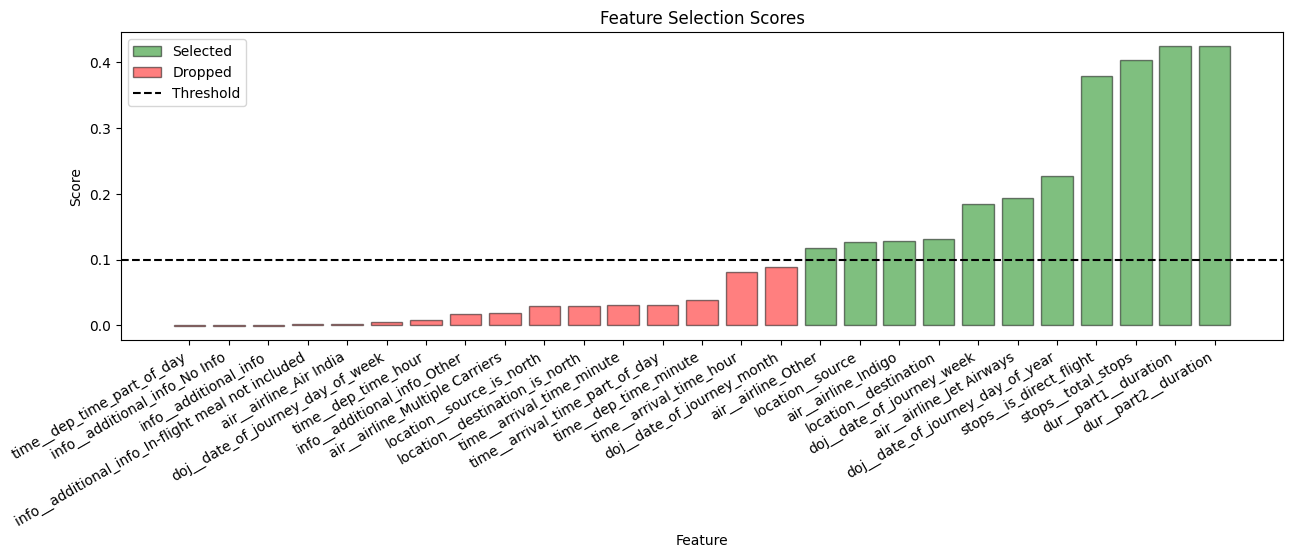

In [43]:
THRESOLD = 0.1
selected_bar = None
dropped_bar = None
colors = ['red' if score < THRESOLD else 'green' for score in sorted_feat_imp.values()]

fig,ax = plt.subplots(figsize=(15,4))

for i,(feature,score) in enumerate(sorted_feat_imp.items()):
    params = dict(
        x=i,
        height = score,
        edgecolor='black',
        alpha=0.5
    )
    if score<THRESOLD:
        bar = ax.bar(
            color = 'red',
            **params
        )
        if not dropped_bar:
            dropped_bar=bar[0]
    else:
            bar = ax.bar(
                color='green',
                **params
            )
            if not selected_bar:
                selected_bar = bar[0]

thresh_line = ax.axhline(
	y=0.1,
	color="black",
	linestyle="--"
)

ax.set_xticks(
	ticks=range(len(sorted_feat_imp)),
	labels=list(sorted_feat_imp.keys()),
	rotation=30,
	ha="right"
)

ax.set(
	xlabel="Feature",
	ylabel="Score",
	title="Feature Selection Scores"
)

ax.legend(
	handles=[selected_bar, dropped_bar, thresh_line],
	labels=["Selected", "Dropped", "Threshold"],
	loc="upper left"
)

plt.show()

### Preprocess Data

In [44]:
PATH_DIR = r'D:\Ml projects\car dekho\flights practice\data'

In [51]:
def get_data(data):
    file = f'{data}.csv'
    path = os.path.join(PATH_DIR,file)
    return pd.read_csv(path)

In [52]:
def export_data(data,name,pre):
    # split data into x and y subset
    x = data.drop(columns='price')
    y = data.price.copy()
    x_pre = pre.transform(x)
    file_name = f'{name}_pre.csv'
    file_path = os.path.join(PATH_DIR,file_name)
    x_pre.join(y).to_csv(file_path,index=False)

In [53]:
export_data(train,'train',preprocessor)

In [54]:
test = get_data('test')
export_data(test,'test',preprocessor)

In [55]:
val = get_data('val')
export_data(val,'val',preprocessor)

### Data

In [69]:
train_pre = get_data('train_pre')

In [71]:
val_pre = get_data('val_pre')

In [72]:
pre_data = {
    'train':train_pre,
    'val':val_pre
}

### Model

### Train the Model

In [59]:
from xgboost import XGBRegressor

In [75]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_squared_error

In [146]:
train_pre = get_data('train_pre')
val_pre = get_data('val_pre')

# Combine train and validation data for cross-validation
full_data = pd.concat([train_pre, val_pre], axis=0)

# Split the data into features and target
X = full_data.drop(columns='price')
y = full_data['price']

# Convert the data to DMatrix format
dtrain = xgb.DMatrix(X, label=y)

# Define the hyperparameter grid
param_grid = {
    'eta': [0.05, 0.1, 0.15, 0.2],
    'max_depth': [3, 4, 5],
    'alpha': [0, 0.5, 1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Initialize the model
model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)

# Initialize GridSearchCV or RandomizedSearchCV
search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,  # 5-fold cross-validation
    n_jobs=-1,  # Use all available cores
    verbose=1
)

# Fit the search object
search.fit(X, y)

# Print the best hyperparameters and the corresponding score
print("Best hyperparameters: ", search.best_params_)
print("Best RMSE: ", (-search.best_score_)**0.5)

# Evaluate the best model on the validation set
best_model = search.best_estimator_
X_val = val_pre.drop(columns='price')
y_val = val_pre['price']
dval = xgb.DMatrix(X_val, label=y_val)
y_pred = best_model.predict(X_val)
rmse = mean_squared_error(y_val, y_pred, squared=False)
print(f'Validation RMSE: {rmse}')

# Calculate accuracy (or another metric if needed)
accuracy = best_model.score(X_val, y_val)
print(f'Validation Accuracy: {accuracy}')


Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best hyperparameters:  {'alpha': 0, 'colsample_bytree': 0.8, 'eta': 0.2, 'max_depth': 4, 'subsample': 1.0}
Best RMSE:  2255.8550082337388
Validation RMSE: 1890.2229800805908
Validation Accuracy: 0.8395137786865234


## Saving model and preprocessor

In [147]:
import pickle
model_path = 'best_model.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(best_model, f)
print(f'Model saved to {model_path}')

Model saved to best_model.pkl


In [148]:
preprocessor_path = 'preprocess.pkl'
with open(preprocessor_path,'wb') as f:
    pickle.dump(preprocessor,f)

### Prediction

In [149]:
import pandas as pd

# New data point
data = ['Jet Airways','2019-03-06','Banglore','New Delhi','08:00:00','08:15:00',1455,1.0,'No Info']
columns= ['airline','date_of_journey','source','destination','dep_time','arrival_time','duration','total_stops','additional_info']

# Create a DataFrame
new_data = pd.DataFrame([data], columns=columns)
new_data

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info
0,Jet Airways,2019-03-06,Banglore,New Delhi,08:00:00,08:15:00,1455,1.0,No Info


In [150]:
import pickle

# Load the model and preprocessor from disk
with open('best_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

with open('preprocess.pkl','rb') as f:
    loaded_preprocessor = pickle.load(f)


In [151]:
# Preprocess the new data point
new_data_preprocessed = loaded_preprocessor.transform(new_data)

# Make prediction
predicted_price = loaded_model.predict(new_data_preprocessed)

print(f'Predicted Price: {predicted_price[0]}')


Predicted Price: 15125.7548828125


In [152]:
test

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Jet Airways,2019-03-06,Banglore,New Delhi,08:00:00,08:15:00,1455,1.0,No Info,17996
1,Spicejet,2019-06-06,Kolkata,Banglore,22:20:00,00:40:00,140,0.0,No Info,3873
2,Indigo,2019-03-18,Kolkata,Banglore,05:30:00,08:20:00,170,0.0,No Info,4462
3,Indigo,2019-06-27,Chennai,Kolkata,19:35:00,21:55:00,140,0.0,No Info,3597
4,Indigo,2019-05-06,Kolkata,Banglore,15:15:00,17:45:00,150,0.0,No Info,4804
...,...,...,...,...,...,...,...,...,...,...
2088,Jet Airways,2019-05-27,Delhi,Cochin,19:15:00,12:35:00,1040,1.0,In-flight meal not included,12898
2089,Multiple Carriers,2019-06-27,Delhi,Cochin,11:25:00,19:15:00,470,1.0,No Info,7155
2090,Jet Airways,2019-06-03,Delhi,Cochin,02:15:00,04:25:00,1570,1.0,In-flight meal not included,11627
2091,Multiple Carriers,2019-06-06,Delhi,Cochin,15:15:00,01:30:00,615,1.0,No Info,6795
